## Импорты

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np

## Функции

In [8]:
# link https://gist.github.com/sebpiq/4128537

def goertzel(samples, sample_rate, *freqs):
    """
    Реализация алгоритма Герцеля, полезного для вычисления отдельных
    частот дискретного преобразования Фурье.

    `samples` - это оконный одномерный сигнал, изначально отсэмплированный на `sample_rate`.

    Функция возвращает 2 массива: один содержит реально вычисленные частоты,
    второй - коэффициенты `(действительная часть, мнимая часть, мощность)` для каждой из этих частот.
    Для простого спектрального анализа достаточно использовать мощность.

    Пример использования:

        freqs, results = goertzel(some_samples, 44100, (400, 500), (1000, 1100))
    """

    window_size = len(samples)
    f_step = sample_rate / float(window_size)
    f_step_normalized = 1.0 / window_size

    # Вычисляем все DFT-бины, которые необходимо вычислить, включая частоты
    # в `freqs`.
    bins = set()
    for f_start, f_end in freqs:
        k_start = int(f_start // f_step)
        k_end = int(f_end // f_step) + 1
        if k_end > window_size - 1:
            raise ValueError(f'частота вне диапазона {k_end}')

        bins.update(range(k_start, k_end))

    # Для всех бинов вычисляем DFT-термы
    freqs = []
    results = []
    n_range = range(window_size)
    for k in bins:
        # Частота бина и коэффициенты для вычисления
        f = k * f_step_normalized
        w_real = 2 * math.cos(2 * math.pi * f)
        w_imag = math.sin(2 * math.pi * f)

        # Выполняем вычисления на всем образце
        d1, d2 = 0, 0
        for n in n_range:
            y = samples[n] + w_real * d1 - d2
            d2, d1 = d1, y

        # Сохраняем результаты `(действительная часть, мнимая часть, мощность)`
        results.append((0.5 * w_real * d1 - d2, w_imag * d1, d2 ** 2 + d1 ** 2 - w_real * d1 * d2))
        freqs.append(f * sample_rate)

    return freqs, results

Encoder - генерация сигнала. 

Decoder - опредееление нажатой клавиши по семплам.

In [13]:
class Params:
    """Параметры, общие для кодировщика и декодировщика. Используются для хранения в одном месте."""
    def __init__(self) -> None:
        self.fs = 10_000
        self.duration = 0.5

class Encoder(Params):
    def __init__(self) -> None:
        super().__init__()
        self.freqs = {
            "1": (697, 1209),
            "2": (697, 1336),
            "3": (697, 1477),
            "4": (770, 1209),
            "5": (770, 1336),
            "6": (770, 1477),
            "7": (852, 1209),
            "8": (852, 1336),
            "9": (852, 1477),
            "0": (941, 1336),
            "a": (697, 1633),
            "b": (770, 1633),
            "c": (852, 1633),
            "d": (941, 1633),
            "*": (941, 1209),
            "#": (941, 1477),
        }

    def encode_tone(self, k: str) -> None:
        """Создание списка сэмплов для одной нажатой клавиши."""
        freqs = self.freqs[k]
        samples = np.mean(
            np.sin(np.outer(freqs, 2 * np.pi * np.arange(self.fs * self.duration) / self.fs)),
            axis=0).astype(np.float32)
        return samples

    def encode(self, sequence: str) -> list[list]:
        """Кодирование последовательности нажатий клавиш. Возвращает список списков, внутренние списки - это сэмплы."""
        return [self.encode_tone(k) for k in sequence]

    def encode_with_noise(self, sequence: str, noise_scale: float = 0.3) -> list[list]:
        """Аналогично encode, но с шумом"""
        return [self.encode_tone(k) + np.random.normal(0, noise_scale, self.encode_tone(k).shape)
                for k in sequence]

class Decoder(Params):
    def __init__(self) -> None:
        super().__init__()
        self.freqs = {
            (697, 1209) : "1",
            (697, 1336) : "2",
            (697, 1477) : "3",
            (770, 1209) : "4",
            (770, 1336) : "5",
            (770, 1477) : "6",
            (852, 1209) : "7",
            (852, 1336) : "8",
            (852, 1477) : "9",
            (941, 1336) : "0",
            (697, 1633) : "a",
            (770, 1633) : "b",
            (852, 1633) : "c",
            (941, 1633) : "d",
            (941, 1209) : "*",
            (941, 1477) : "#",
        }

        WINDOW_WIDTH = 50
        self.low_freqs = [697, 770, 852, 941]
        self.low_freqs = {x:[x - WINDOW_WIDTH, x + WINDOW_WIDTH] for x in self.low_freqs}
        self.high_freqs = [1209, 1336, 1477, 1633]
        self.high_freqs = {x:[x - WINDOW_WIDTH, x + WINDOW_WIDTH] for x in self.high_freqs}

    def decode(self, samples: list[list]) -> list:
        """Декодирование нажатых клавиш."""
        res = []
        for s in samples:
            low = []
            for freq in self.low_freqs:
                freq_interval = self.low_freqs[freq]
                _, results = goertzel(s, self.fs, freq_interval)
                r = np.array(results)[:, 2]
                low.append([np.max(r), freq])
            low_freq = max(low)[1]

            high = []
            for freq in self.high_freqs:
                freq_interval = self.high_freqs[freq]
                _, results = goertzel(s, self.fs, freq_interval)
                r = np.array(results)[:, 2]
                high.append([np.max(r), freq])
            high_freq = max(high)[1]

            res.append(self.freqs[(low_freq, high_freq)])
        return res

    def draw_spectrum(self, samples: list) -> None:
        "График спектра для одного сигнала"
        freqs, results = goertzel(samples, self.fs, (600, 1700))
        r = np.array(results)[:,2]

        fig, ax = plt.subplots(dpi=50)
        ax.set_xlabel("Frequency, Hz")
        ax.set_title(f"Spectrum")
        ax.plot(freqs, r)
        fig.show()

## Реализация

In [10]:
e = Encoder()
d = Decoder()

keys_pressed = "1801"
samples = e.encode(keys_pressed)
decoded = d.decode(samples)

print(*decoded, sep="")

1801


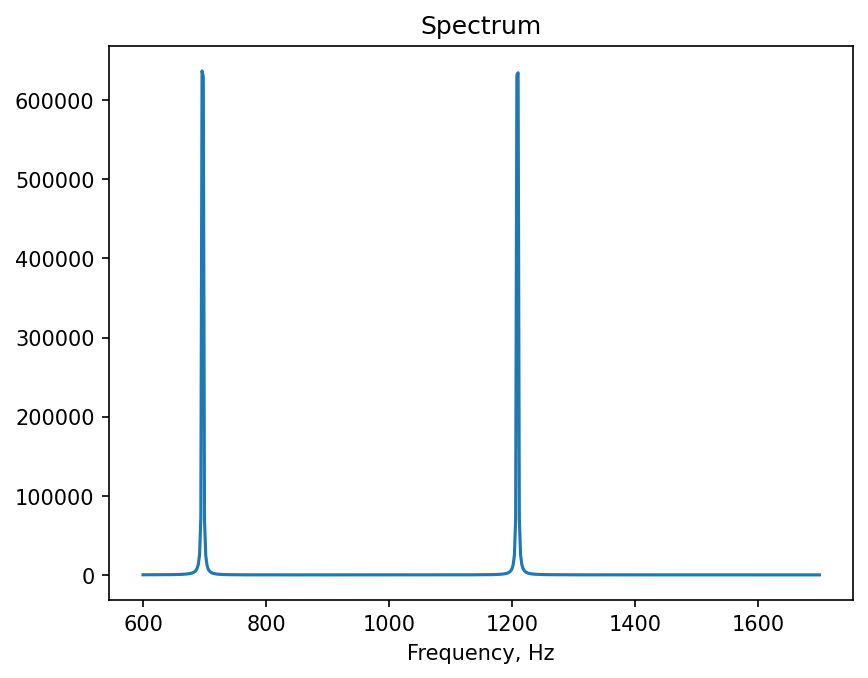

In [14]:
samples = e.encode("1")[0]
d.draw_spectrum(samples)

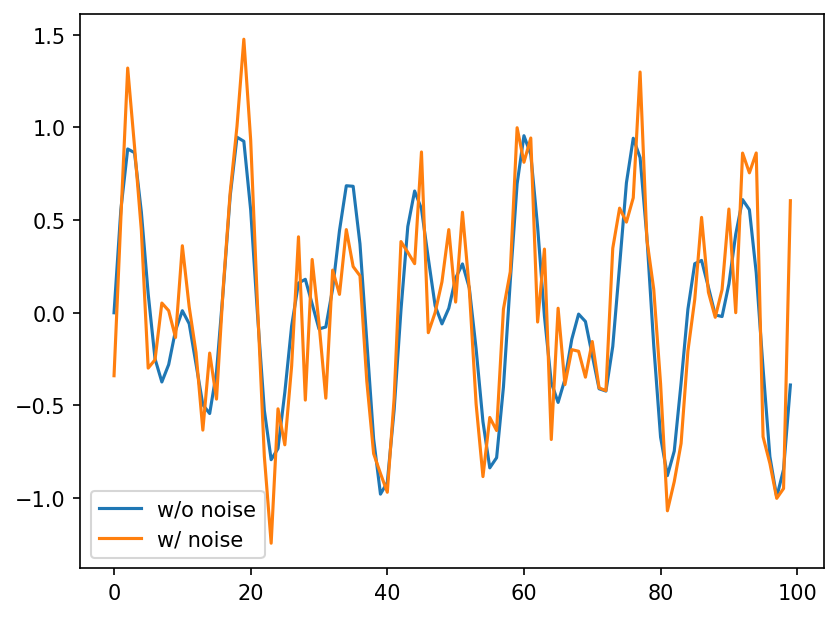

In [15]:
# шум

keys_pressed = "1"
samples = e.encode(keys_pressed)
samples_with_noise = e.encode_with_noise(keys_pressed)

fig, ax = plt.subplots(dpi=150)
ax.plot(np.array(samples[0][:100]), label="w/o noise")
ax.plot(np.array(samples_with_noise[0][:100]), label="w/ noise")
ax.legend()
fig.show()